In [3]:
import pickle 
import LoadData as data
import numpy as np
from GNE import GNE
from evaluation import *
from utils import *
import pandas as pd
import scipy.sparse as sp
import random
import pandas as pd

In [ ]:
def split_seq(seq, num_splits):
        newseq = []
        splitsize = 1.0/num_splits*len(seq)
        for i in range(num_splits):
                newseq.append(seq[int(round(i*splitsize)):int(round((i+1)*splitsize))])
        return newseq

In [1]:
path = './data/yeast/'

In [4]:
geneids = pd.read_csv(path + "gene_ids.tsv", sep="\t")

In [5]:
num_genes = geneids.shape[0]
link_file = path + "edgelist_biogrid.txt"

adj = load_network(link_file, num_genes)

### Loading [./data/yeast/edgelist_biogrid.txt]...


In [6]:
np.sum(adj)

544652.0

In [ ]:
def create_dataset_for_comparison(path, adj):
    print("Creating 2 split of data")
    g = nx.Graph(adj)
    adj = nx.to_scipy_sparse_matrix(g)
    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()

    # Split link information to train and validation with test split size
    edgelist = convertAdjMatrixToSortedRankTSV(adj.todense())
    geneids = edgelist.iloc[:, :2]
    col1 = np.array(geneids).min(axis=1).astype(int)
    col2 = np.array(geneids).max(axis=1).astype(int)
    col3 = np.array(edgelist.iloc[:, 2])
    data_df = pd.DataFrame()
    data_df['i'] = col1
    data_df['j'] = col2
    data_df['k'] = col3
    data_df = data_df.drop_duplicates()

    pos_edges = data_df.loc[data_df.iloc[:, 2] == 1]
    neg_edgelist = data_df.loc[data_df.iloc[:, 2] == 0]
    ind = random.sample(range(len(neg_edgelist)), pos_edges.shape[0])
    neg_edges = pd.DataFrame(np.random.permutation(neg_edgelist.values))
    neg_edges = neg_edges.iloc[ind, :]

#     assert set(map(tuple, pos_edges)).isdisjoint(set(map(tuple, neg_edges)))
    return pos_edges, neg_edges

In [ ]:
X_pos, X_neg = create_dataset_for_comparison(path, adj)

In [ ]:
X_pos, X_neg = X_pos.values, X_neg.values

In [ ]:
X_pos, X_neg = X_pos.astype(int), X_neg.astype(int)

In [ ]:
randomized_indices = np.random.permutation(range(len(X_pos)))

In [ ]:
index_splits = split_seq(range(len(X_pos)), 2)

In [ ]:
test_index = randomized_indices[index_splits[1]]

In [ ]:
train_index = randomized_indices[index_splits[0]]

In [ ]:
train_edges = X_pos[train_index,:]
train_edges_false = X_neg[train_index,:]
val_edges = X_pos[train_index,:]
val_edges_false = X_neg[train_index,:]
test_edges = X_pos[test_index,:]
test_edges_false = X_neg[test_index,:]

In [ ]:
# pd.DataFrame(train_edges).to_csv("/Users/kk3671/Documents/Op÷enNE/data/yeast/train_links_0.5_split_1.txt", index=False, header=False, sep=' ')

In [ ]:
# pd.DataFrame(test_edges).to_csv("/Users/kk3671/Documents/OpenNE/data/yeast/train_links_0.5_split_2.txt", index=False, header=False, sep=' ')

In [ ]:
train_data = np.concatenate([train_edges, train_edges_false])
test_data =  np.concatenate([test_edges, test_edges_false])

In [ ]:
pd.DataFrame(train_data).to_csv("/Users/kk3671/Documents/OpenNE/data/yeast/train_data_1.txt", index=False, header=False, sep=' ')
pd.DataFrame(test_data).to_csv("/Users/kk3671/Documents/OpenNE/data/yeast/train_data_2.txt", index=False, header=False, sep=' ')

In [ ]:
train_data = pd.read_csv("/Users/kk3671/Documents/OpenNE/data/yeast/train_data_1.txt", header=None, sep=' ')
test_data = pd.read_csv("/Users/kk3671/Documents/OpenNE/data/yeast/train_data_2.txt",  header=None, sep=' ')

In [ ]:
train_edges = train_data.loc[train_data.iloc[:,2]==1].values
train_edges_false = train_data.loc[train_data.iloc[:,2]==0].values
val_edges = train_data.loc[train_data.iloc[:,2]==1].values
val_edges_false = train_data.loc[train_data.iloc[:,2]==0].values
test_edges = test_data.loc[test_data.iloc[:,2]==1].values
test_edges_false = test_data.loc[test_data.iloc[:,2]==0].values

In [ ]:
train_edges.shape

In [ ]:
validation_edges =  np.concatenate([val_edges, val_edges_false])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

In [ ]:
a1_rows = set(map(tuple, train_edges))

In [ ]:
a2_rows = set(map(tuple, test_edges))

In [ ]:
a1_rows.isdisjoint(a2_rows)

In [13]:
feature_file = path + 'expression_data.tsv'

In [7]:
from convertdata import *

In [8]:
dataset = create_train_test_split(path, adj, test_size=0.1, validation_size=0.1)

Creating train test and validation_split


In [9]:
train_edges = dataset['train_pos']
train_edges_false = dataset['train_neg']
val_edges = dataset['val_pos']
val_edges_false = dataset['val_neg']
test_edges = dataset['test_pos']
test_edges_false = dataset['test_neg']

In [10]:
# Inspect train/test split
print("Total nodes:", adj.shape[0])
print("Total edges:", np.sum(adj))  # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
print("Training edges (negative):", len(train_edges_false))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 5950
Total edges: 544652.0
Training edges (positive): 395875
Training edges (negative): 395875
Validation edges (positive): 43987
Validation edges (negative): 43987
Test edges (positive): 48874
Test edges (negative): 48874


In [11]:
validation_edges =  np.concatenate([val_edges, val_edges_false])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

In [14]:
Data = data.LoadData(path, train_links=train_edges, features_file=feature_file)

Constructing Nodes
attr_M: 536
id_N: 5950
Reading training links
Constructing Neighborhood maps
Constructing train data


In [15]:
len(Data.links)

791750

In [16]:
len(test_edges)

48874

In [17]:
len(validation_edges)

87974

In [18]:
parameters = {}
parameters['id_embedding_size'] = 128
parameters['attr_embedding_size'] = 128
parameters['batch_size'] = 256
parameters['alpha'] = 0
parameters['n_neg_samples'] = 10
parameters['epoch'] = 20
parameters['representation_size'] = 128
parameters['learning_rate'] = 0.005
parameters

{'alpha': 0,
 'attr_embedding_size': 128,
 'batch_size': 256,
 'epoch': 20,
 'id_embedding_size': 128,
 'learning_rate': 0.005,
 'n_neg_samples': 10,
 'representation_size': 128}

In [19]:
for i in [0,1]:
    parameters['alpha'] = i
    model = GNE(path, Data, 2018, parameters)
    embeddings = model.train(validation_edges, val_edge_labels)
    pd.DataFrame(embeddings).to_csv("embeddings_yeast_alpha_"+str(parameters['alpha'])+".txt", header=False, index=False, sep=",")

{'id_embedding_size': 128, 'attr_embedding_size': 128, 'batch_size': 256, 'alpha': 0, 'n_neg_samples': 10, 'epoch': 20, 'representation_size': 128, 'learning_rate': 0.005}
Using structure and attribute embedding
Epoch:      1, Train-Batch Loss: 6.310084483, Validation AUC: 0.557508353 *
Epoch:      2, Train-Batch Loss: 1.949577686, Validation AUC: 0.563390622 *
Epoch:      3, Train-Batch Loss: 1.582844538, Validation AUC: 0.590562869 *
Epoch:      4, Train-Batch Loss: 1.516007597, Validation AUC: 0.638523756 *
Epoch:      5, Train-Batch Loss: 1.492391334, Validation AUC: 0.685045378 *
Epoch:      6, Train-Batch Loss: 1.433447374, Validation AUC: 0.718403083 *
Epoch:      7, Train-Batch Loss: 1.402797732, Validation AUC: 0.738265165 *
Epoch:      8, Train-Batch Loss: 1.371006530, Validation AUC: 0.750990422 *
Epoch:      9, Train-Batch Loss: 1.387766419, Validation AUC: 0.758661669 *


/Users/kk3671/Documents/GNE_bk/evaluation.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch:     10, Train-Batch Loss: 1.355640317, Validation AUC: 0.762884010 *
Epoch:     11, Train-Batch Loss: 1.360708615, Validation AUC: 0.763946740 *
Epoch:     12, Train-Batch Loss: 1.364342529, Validation AUC: 0.761929607 
Epoch:     13, Train-Batch Loss: 1.342732669, Validation AUC: 0.759919975 
Epoch:     14, Train-Batch Loss: 1.312292517, Validation AUC: 0.757366515 
No improvement found in a while, stopping optimization.
{'id_embedding_size': 128, 'attr_embedding_size': 128, 'batch_size': 256, 'alpha': 1, 'n_neg_samples': 10, 'epoch': 20, 'representation_size': 128, 'learning_rate': 0.005}
Using structure and attribute embedding
Epoch:      1, Train-Batch Loss: 7.703314566, Validation AUC: 0.666438791 *
Epoch:      2, Train-Batch Loss: 4.920528603, Validation AUC: 0.707863075 *
Epoch:      3, Train-Batch Loss: 2.679996250, Validation AUC: 0.746812381 *
Epoch:      4, Train-Batch Loss: 1.687004831, Validation AUC: 0.757842852 *
Epoch:      5, Train-Batch Loss: 1.603077887, Valid

In [20]:
embeddings_1 = pd.read_csv("embeddings_yeast_alpha_0.txt", header=None, sep=",")
embeddings_2 = pd.read_csv("embeddings_yeast_alpha_1.txt", header=None, sep=",")

In [21]:
embeddings_1 = embeddings_1.values
embeddings_2 = embeddings_2.values

In [22]:
# Train-set edge embeddings
pos_train_edge_embs = get_edge_embeddings(embeddings_1, train_edges)
neg_train_edge_embs = get_edge_embeddings(embeddings_1, train_edges_false)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])
# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

In [23]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression

edge_classifier_1 = LogisticRegression(random_state=0)
edge_classifier_1.fit(train_edge_embs, train_edge_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
# test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
# test_roc = roc_auc_score(test_edge_labels, test_preds)
# test_ap = average_precision_score(test_edge_labels, test_preds)

In [ ]:
# print('GNE Test ROC score: ', str(test_roc))
# print('GNE Test AP score: ', str(test_ap))

In [24]:
# Train-set edge embeddings
pos_train_edge_embs = get_edge_embeddings(embeddings_2, train_edges)
neg_train_edge_embs = get_edge_embeddings(embeddings_2, train_edges_false)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])

In [25]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression

edge_classifier_2 = LogisticRegression(random_state=0)
edge_classifier_2.fit(train_edge_embs, train_edge_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
# Ecoli
#GNE Test ROC score:  0.940158504921
#GNE Test AP score:  0.93897040116

In [ ]:
# yeast
# GNE Test ROC score:  0.821812518988
# GNE Test AP score:  0.80728890868

In [26]:
evaluation_data = pd.read_csv("/Users/kk3671/Documents/GNE/data/yeast/evaluation_data.txt", header=None, sep=" ")

In [27]:
test_edges = evaluation_data.iloc[:,:2].values

In [28]:
test_pos = evaluation_data.loc[evaluation_data.iloc[:,2]==1,:]

In [29]:
index = np.random.permutation(test_edges_false.shape[0])[:test_pos.shape[0]]

In [30]:
test_edges_neg = test_edges_false[index,:]

In [31]:
test_edges_data = np.concatenate([test_pos.values,test_edges_neg])

In [32]:
test_edge_labels = np.concatenate([np.ones(len(test_pos)), np.zeros(len(test_edges_neg))])

In [33]:
test_edge_embs = get_edge_embeddings(embeddings, test_edges_data)

In [ ]:
# test_edge_labels = evaluation_data.iloc[:,2].values

In [34]:
test_preds = edge_classifier_1.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds)
test_ap = average_precision_score(test_edge_labels, test_preds)
print('GNE Test ROC score: ', str(test_roc))
print('GNE Test AP score: ', str(test_ap))

GNE Test ROC score:  0.701490073054
GNE Test AP score:  0.685019702035


In [35]:
test_preds_all = edge_classifier_2.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds_all)
test_ap = average_precision_score(test_edge_labels, test_preds_all)
print('GNE Test ROC score: ', str(test_roc))
print('GNE Test AP score: ', str(test_ap))

GNE Test ROC score:  0.714396129958
GNE Test AP score:  0.690655808085


In [ ]:
# structure
# CNE Test ROC score:  0.6852121037
# GNE Test AP score:  0.676090762932
# all
# GNE Test ROC score:  0.707318321648
# GNE Test AP score:  0.679146387378

In [36]:
predictions = evaluation_data

In [37]:
predictions['structure'] = test_preds

In [38]:
predictions['all'] = test_preds_all

In [39]:
predictions_true = predictions.loc[predictions.iloc[:,2]==1]
predictions_true

,0,1,2,structure,all
0,3844,5174,1,0.690379,0.705964
1,1275,2873,1,0.189159,0.104340
2,1824,5545,1,0.361572,0.626138
3,3143,4530,1,0.500160,0.488627
4,2100,3020,1,0.506807,0.771675
5,4350,2873,1,0.334140,0.308406
6,39,4854,1,0.682290,0.726682
7,1702,3752,1,0.542675,0.831660
8,4116,164,1,0.595382,0.679016
9,1225,179,1,0.359938,0.485050


In [ ]:
# predict÷ions_bk =predictions.copy(

In [ ]:
# predictions = predictions_true

In [ ]:
# Structure only
# GNE Test ROC score:  0.779685103723
# GNE Test AP score:  0.781139913429

In [ ]:
# all only
# GNE Test ROC score:  0.827404280591
# GNE Test AP score:  0.824513278629

In [40]:
predictions['structure_rank'] = predictions['structure'].rank(ascending=False, method="dense")
predictions['all_rank'] = predictions['all'].rank(ascending=False, method="dense")

In [41]:
improved_predictions = predictions.loc[ (predictions.loc[:,'structure']<=predictions.loc[:,'all'])]

In [42]:
improved_predictions['diff'] = predictions.loc[:,'all'] - predictions.loc[:,'structure']

/Users/kk3671/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
np.mean(improved_predictions['diff'])

0.10363891807634915

In [48]:
improved_predictions = improved_predictions.loc[improved_predictions.loc[:,2]==1]

In [49]:
improved_predictions.sort_values(['diff'], ascending=0)

,0,1,2,structure,all,structure_rank,all_rank,diff
1043,2615,1799,1,0.310224,0.858648,15685.0,1796.0,0.548424
11542,3630,5545,1,0.257449,0.754420,18306.0,3790.0,0.496972
9045,1000,5444,1,0.254082,0.718622,18474.0,4467.0,0.464540
2800,1958,735,1,0.349644,0.808827,13784.0,2715.0,0.459183
1948,5205,735,1,0.315456,0.773419,15453.0,3397.0,0.457963
796,1227,4533,1,0.375480,0.817411,12599.0,2562.0,0.441931
6385,878,735,1,0.440086,0.877601,9960.0,1450.0,0.437515
1748,4012,4291,1,0.391820,0.826919,11897.0,2375.0,0.435099
12495,1092,735,1,0.421663,0.855643,10657.0,1836.0,0.433980
3091,4825,735,1,0.453174,0.885383,9481.0,1298.0,0.432209


In [51]:
improved_predictions.to_csv("../Gene-Network-Embedding/data/yeast/improved_predictions_latest.txt", index=False, header=False, sep=",")

In [65]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt

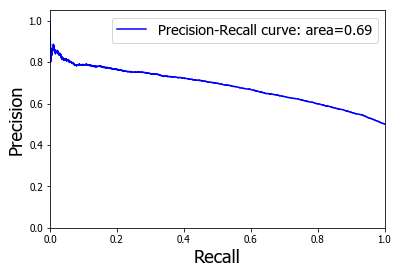

In [66]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Recall", fontsize=18)
# ax.axhline(y=0.839)
ax.set_ylabel("Precision", fontsize=18)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

precision, recall, thresholds = precision_recall_curve(test_edge_labels, test_preds)

ax.plot(recall, precision, color='b', alpha=1, label ="Precision-Recall curve: area={0:0.2f}".format(test_ap))
ax.legend(fontsize='x-large')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.savefig('yeast_pr_curve.eps', dpi =1200)
plt.show()

In [ ]:
thresholds

In [ ]:
import scikitplot as skplt

In [ ]:
skplt.metrics.plot_precision_recall_curve(test_labels, edge_classifier.predict_proba(test_data))

In [ ]:
test_preds

In [ ]:
test_labels

In [ ]:
df = pd.DataFrame(test_edges.astype(int))

In [ ]:
df

In [ ]:
df['predicted'] = test_preds

In [ ]:
df = df.sort_values(['predicted'], ascending=False)

In [ ]:
df.to_csv("../Gene-Network-Embedding/data/yeast/predictions.txt", index=False, header=False, sep=",")

In [ ]:
test_roc = roc_auc_score(df.iloc[:,2], df.iloc[:,3])
test_ap = average_precision_score(df.iloc[:,2], df.iloc[:,3])

In [ ]:
print('GNE Test ROC score: ', str(test_roc))
print('GNE Test AP score: ', str(test_ap))